In [39]:
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp

num_genre    = 10
num_contents = 600
num_user     = 100
num_request  = 100

def gamma_dist(gamma_a, gamma_b):
    s = 0
    p = [0 for _ in range(num_genre)]
    for i in range(1,num_genre+1):
        p[i-1] = i**(gamma_a-1)*math.exp(-i*gamma_b)
        s+= p[i-1]
        
    #for i in range(num_genre):
    for i in range(1,num_genre+1):
        p[i-1]/=s

    return p

## Mzipf of contents prob per genre
def contents_dist(q_m, gamma_m):
    n = num_contents//num_genre
    p_m = [0 for _ in range(n)]
    #q_m = 64
    #gamma_m = 5
    sum = 0
    for i in range(n):
        p_m[i] = (i+q_m)**(-gamma_m)
        sum += p_m[i]
    for i in range(n):
        p_m[i] /= sum

    return p_m

## Mzipf of Individual Genre prob
def genre_dist(q_m, gamma_m):
    n = num_genre
    p_m = [0 for i in range(n)]
    #q_m = 64
    #gamma_m = 5
    sum = 0
    for i in range(n):
        p_m[i] = (i+q_m)**(-gamma_m)
        sum+=p_m[i]

    for i in range(n):
        p_m[i] /= sum
    return p_m

def graph(p):
    plt.plot([i for i in range(len(p))], p)
    plt.show()
    

## Sampling
def CDF(p):    
    dist = [0 for i in range(len(p))]
    for i in range(len(p)):
        for j in range(0, i+1):
            dist[i] += p[j]

    dist = np.array(dist)
    return dist

def binary_search(cdf, target, left, right):
    while left < right:
        mid = (left + right) // 2
        if cdf[mid] < target:
            left = mid + 1
        else:
            right = mid
    return left

def inverse_transform_sampling(cdf, n_samples, left, right):
    u = np.random.rand(n_samples)
    samples = [binary_search(cdf, uu, left, right) for uu in u]
    return samples

def sort_rank(ref, comp, data):
    # sort comp's data as ref's order
    ans = []
    num_contents//num_genre
    for i in ref:
        idx = comp.index(i)
        ans+=data[idx*num_contents//num_genre : (idx+1)*num_contents//num_genre]
    
    return ans

def sort_contents(ref, comp, data):
    # sort comp's data as ref's order
    ans = [[] for _ in range(num_user)]
    num_contents//num_genre
    for idx, u in enumerate(data):
        for j in u:
            g = j//(num_contents//num_genre)
            c = j%(num_contents//num_genre)
            gc = comp[g]
            gr = ref.index(gc)
            ans[idx].append(gr*num_contents//num_genre + c)
    
    return ans

In [40]:
## Generate Zone feature as Genre
zone1 = gamma_dist(3, 0.8)
zone2 = gamma_dist(2.6,0.75)
# zone1 = CDF(zone1)
# zone2 = CDF(zone2)
z1 = []
z2 = []

for i in range(num_genre):
    z1.append((i, zone1[i]))
    z2.append((i, zone2[i]))
z1.sort(key = lambda x : (-x[1], x[0]))
z2.sort(key = lambda x : (-x[1], x[0]))

In [41]:
g_rank1 = []
g_rank2 = []
for i in z1:
    g_rank1.append(i[0])

for i in z2:
    g_rank2.append(i[0])
    
print("Ranking Order of Genre")
print(g_rank1)
print(g_rank2)

Ranking Order of Genre
[2, 1, 3, 4, 0, 5, 6, 7, 8, 9]
[1, 2, 0, 3, 4, 5, 6, 7, 8, 9]


In [42]:
## Generate User Prefernece of Genre
u_g = []
p_g = []
for i in range(2*num_user):
    q_m   = 64 + i/2
    gamma = 5 + i/2
    u_g.append(genre_dist(q_m, gamma))
    p_g.append(CDF(u_g[i]))
    #graph(u_dist[i])
    
## Generate User Preference of Contents per Genre
u_c = []
p_c = []
for i in range(num_genre):
    q_m   = 64 + i/2
    gamma = 5 + i/2
    u_c.append(contents_dist(q_m, gamma))
    p_c.append(CDF(u_c[i]))
    #graph(u_dist[i])

g1 = []
g2 = []
for u in range(0, num_user):
    temp = []
    sample1 = inverse_transform_sampling(cdf = p_g[u], n_samples=num_request, left = 0, right = 9)
    for i in sample1:
        temp.append(i*num_contents//num_genre+inverse_transform_sampling(cdf = p_c[i], n_samples=1, left = 0, right = num_contents//num_genre)[0])
    g1+=[temp]

for u in range(num_user, num_user*2):
    temp = []
    sample2 = inverse_transform_sampling(cdf = p_g[u], n_samples=num_request, left = 0, right = 9)
    for i in sample2:   
        temp.append(i*num_contents//num_genre+inverse_transform_sampling(cdf = p_c[i], n_samples=1, left = 0, right = num_contents//num_genre)[0])
    g2+=[temp]

In [43]:
g2 = sort_contents(g_rank1, g_rank2, g2)

In [44]:
qt1 = [0 for _ in range(num_contents)]
for i in g1:
    for j in i:
        qt1[j]+=1
    
qt2 = [0 for _ in range(num_contents)]
for i in g2:
    for j in i:
        qt2[j]+=1
        

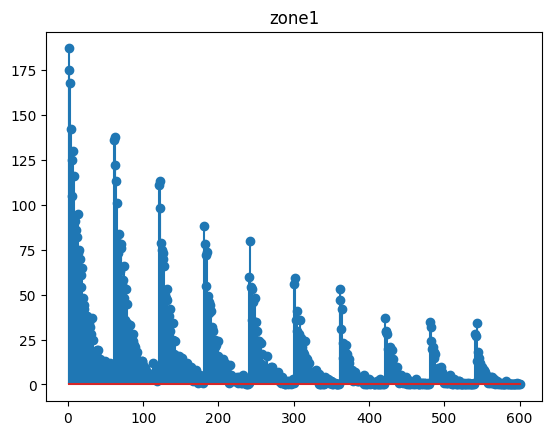

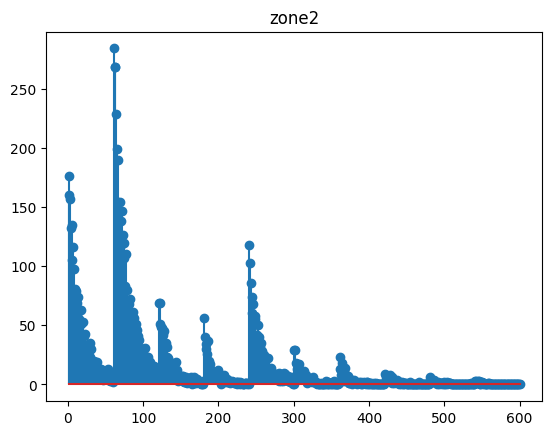

In [45]:
# qqt2 = sort_rank(g_rank1, g_rank2, qt2)
plt.stem([i+1 for i in range(num_contents)], qt1)
plt.title("zone1")
plt.show()
plt.stem([i+1 for i in range(num_contents)], qt2)
plt.title("zone2")
plt.show()

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        input_size = 600  # 입력 벡터 크기
        hidden_size = 256  # 은닉층 크기
        latent_size = 32  # 잠재 변수 크기
        num_categories = 600  # 이산 확률 분포의 카테고리 수
        temperature = 15  # Gumbel-Softmax relaxation의 온도 매개변수

        super(VAE, self).__init__()
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_categories = num_categories
        self.temperature = temperature

        # Encoder
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc_mean = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        # Decoder
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_categories)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = eps.mul(std).add_(mean)
        else:
            z = mean
        return z

    def gumbel_softmax(self, logits):
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) + 1e-8) + 1e-8)
        softmax = F.softmax((logits + gumbel_noise) / self.temperature, dim=-1)
        return softmax

    def decode(self, z):
        h = F.relu(self.fc3(z))
        logits = self.fc4(h)
        probas = self.gumbel_softmax(logits)
        return probas

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mean, logvar

    def sample(self, num_samples=1):
        z = torch.randn(num_samples, self.latent_size).to("cuda:0")
        probas = self.decode(z)
        return probas

In [47]:
import torch
from torch import optim
from torch import nn
from torch.autograd import Variable

class ES():
    def __init__(self, size, load, device, smodel):
        self.size = size
        self.smodel = smodel
        self.model  = VAE().to(device)
        self.clients = [None]*size
        self.count = 0
        self.load =load
        self.load_s = 0
        self.device = device
        for i in load:
            self.load_s+=i
            
    @staticmethod
    def __average_weights(self,clients):
        for idx, info in enumerate(clients[1:]):
            for key in info:
                #clients[0][key]=info[key] + clients[0][key]
                if(idx == 0):
                    clients[0][key]=self.load[idx+1]*info[key] + self.load[idx]*clients[0][key]
                else:
                    clients[0][key]=self.load[idx+1]*info[key] + clients[0][key]
                    
        for key in clients[0]:
            #clients[0][key]=clients[0][key]/self.size  
            clients[0][key]=clients[0][key]/self.load_s
        weights=clients[0]
        return weights

    def aggregate(self):
        ## overlapped client weight gamma needed 
        weights_info = self.clients
        weights = self.__average_weights(self,weights_info)
        self.model.load_state_dict(weights)
        
    def train(self):
        print("Progress of Synthesis")
        nmodel = VAE().to("cuda:0")
        optimizer = optim.Adam(nmodel.parameters(), lr=1e-3)
        num_epochs = 10
        for _ in range(5*num_epochs):
        #batch = self.data
            for _ in range(num_epochs):
                nmodel.train()
                train_loss = 0.0
                inputs = self.model.sample()
                optimizer.zero_grad()
                reconstructed_x, mean, logvar = nmodel(inputs)

                # Reconstruction loss
                reconstruction_loss = F.binary_cross_entropy(reconstructed_x, inputs, reduction='sum')

                # KL divergence loss
                kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

                # Total loss
                loss = reconstruction_loss + kl_divergence_loss
                train_loss += loss.item()
                
                loss.backward()
                optimizer.step()
            
            for _ in range(num_epochs//2):
                nmodel.train()
                train_loss = 0.0
                #batch = [batch]
                #batch = torch.tensor(batch, dtype=torch.float32).to(self.ES.device)
                #inputs = data.to('cuda:0')
                inputs = self.smodel.sample()
                optimizer.zero_grad()
                reconstructed_x, mean, logvar = nmodel(inputs)
                # Reconstruction loss
                reconstruction_loss = F.binary_cross_entropy(reconstructed_x, inputs, reduction='sum')
                # KL divergence loss
                kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
                # Total loss
                loss = reconstruction_loss + kl_divergence_loss
                train_loss += loss.item()
                loss.backward()
                optimizer.step()

        # Print progress
        #print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss ))
        weights = nmodel.state_dict()
        return weights
        
    def global_weight(self):
        weights = self.model.state_dict()
        return weights
    def sample(self):
        return self.model.sample()

class Client(object):
    def __init__(self, rank, data, local_epoch, ES):
        # seed
        seed = 19201077 + 19950920 + rank
        torch.manual_seed(seed)
        self.rank = rank
        self.local_epoch = local_epoch
        self.ES=ES
        self.data = data 

    @staticmethod
    def __load_global_model(self):
        model = VAE().to(self.ES.device)
        model.load_state_dict(self.ES.model.state_dict())
        return model
    
    def __train(self, model):
        # update local model
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        num_epochs = 10
        batch = self.data
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            #batch = [batch]
            batch = torch.tensor(batch, dtype=torch.float32).to(self.ES.device)
            #inputs = data.to('cuda:0')
            inputs = batch
            optimizer.zero_grad()
            reconstructed_x, mean, logvar = model(inputs)

            # Reconstruction loss
            reconstruction_loss = F.binary_cross_entropy(reconstructed_x, inputs, reduction='sum')

            # KL divergence loss
            kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

            # Total loss
            loss = reconstruction_loss + kl_divergence_loss
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        # Print progress
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss ))
        weights=model.state_dict()
        return weights

    def run(self):
        model = self.__load_global_model(self)
        weights = self.__train(model)
        self.ES.clients[self.ES.count%self.ES.size]=weights
        self.ES.count+=1
        
        

In [48]:
load1 = [num_request for i in range(num_user)]

src1 = [[0 for _ in range(num_contents)] for _ in range(num_user)]
src2 = [[0 for _ in range(num_contents)] for _ in range(num_user)]

for i in range(len(g1)):
    for j in g1[i]:
        src1[i][j]+=1
        
for i in range(len(g2)):
    for j in g2[i]:
        src2[i][j]+=1

In [49]:
import pickle
import copy
with open("w_zone1.pkl", "rb") as f:
    w1 = pickle.load(f)

with open("w_zone2.pkl", "rb") as f:
    w2 = pickle.load(f)
    
    
def graph_m(model):
    temp = [0 for i in range(num_contents)]
    for i in range(100000):
        t1 = model.sample().tolist()[0]
        for i in range(len(temp)):
            temp[i]+=t1[i]
    for i in range(len(temp)):
        temp[i]/=100000
    plt.stem([i+1 for i in range(len(temp))],temp,'r',label = 'prediction')
    plt.title("Probability Distribution of Movie Popularity")
    plt.xlabel("Movie ID")
    plt.ylabel("Probability")
    plt.legend(loc ='best')
    plt.show()




def fed_VAE():
    # hyper parameter
    n_ES       = 2
    n_client   = num_user//2
    ES_epoch    = 100
    ESs = []
    #ES_client = [[] for j in range(n_ES) ]
    clients = [[ None for i in range(n_client)] for j in range(n_ES) ]
    model1 = VAE().to("cuda:0")
    model2 = VAE().to("cuda:0")
    model1.load_state_dict(w1)
    model2.load_state_dict(w2)
    m = [model1, model2]
    print('Initialize Dataset...')
    for i in range(n_ES):
        ESs.append(ES(size=n_client, load = load1, device = "cuda:0", smodel = m[i]))
        for j in range(n_client):
            if(i == 0):
                src = src2
            if(i == 1):
                src = src1
            clients[i][j]=Client(rank=j, data = src[j],local_epoch=10, ES = ESs[i] )

    for ESe in range(ES_epoch):
        print('\n================== Edge Server Epoch {:>3} =================='.format(ESe + 1))
        for ESn in range(n_ES):
            #print("================= Edge Server :",ESn,"process =================")
            for c in clients[ESn]:
                c.run()
                
            ESs[ESn].aggregate()
    c_weight1 = copy.deepcopy(ESs[0].global_weight())
    c_weight2 = copy.deepcopy(ESs[1].global_weight())
    weight1 = ESs[0].train()
    weight2 = ESs[1].train()

    return c_weight1, c_weight2, weight1, weight2
if __name__ == '__main__':
    cw1, cw2, w1, w2 = fed_VAE()

Initialize Dataset...

================== Edge Server Epoch   1 ==================
Epoch [10/10], Loss: 635.4705
Epoch [10/10], Loss: 635.4106
Epoch [10/10], Loss: 635.9024
Epoch [10/10], Loss: 637.3749
Epoch [10/10], Loss: 638.2734
Epoch [10/10], Loss: 635.7208


C:\Users\amky9\AppData\Local\Temp\ipykernel_19744\3523631593.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=torch.float32).to(self.ES.device)


Epoch [10/10], Loss: 636.6888
Epoch [10/10], Loss: 637.1882
Epoch [10/10], Loss: 634.7181
Epoch [10/10], Loss: 637.8373
Epoch [10/10], Loss: 635.4956
Epoch [10/10], Loss: 638.7444
Epoch [10/10], Loss: 635.7413
Epoch [10/10], Loss: 637.7100
Epoch [10/10], Loss: 638.7024
Epoch [10/10], Loss: 635.5930
Epoch [10/10], Loss: 636.2104
Epoch [10/10], Loss: 637.5431
Epoch [10/10], Loss: 635.6550
Epoch [10/10], Loss: 636.4358
Epoch [10/10], Loss: 635.1094
Epoch [10/10], Loss: 635.0099
Epoch [10/10], Loss: 636.5156
Epoch [10/10], Loss: 638.7110
Epoch [10/10], Loss: 638.3859
Epoch [10/10], Loss: 636.2031
Epoch [10/10], Loss: 637.2759
Epoch [10/10], Loss: 636.2195
Epoch [10/10], Loss: 639.4818
Epoch [10/10], Loss: 635.9974
Epoch [10/10], Loss: 638.0269
Epoch [10/10], Loss: 638.0939
Epoch [10/10], Loss: 634.4160
Epoch [10/10], Loss: 636.5433
Epoch [10/10], Loss: 637.4004
Epoch [10/10], Loss: 638.6848
Epoch [10/10], Loss: 635.7468
Epoch [10/10], Loss: 636.2523
Epoch [10/10], Loss: 638.7233
Epoch [10/

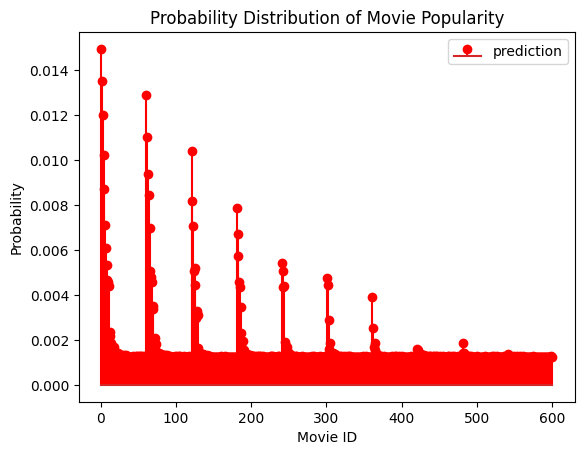

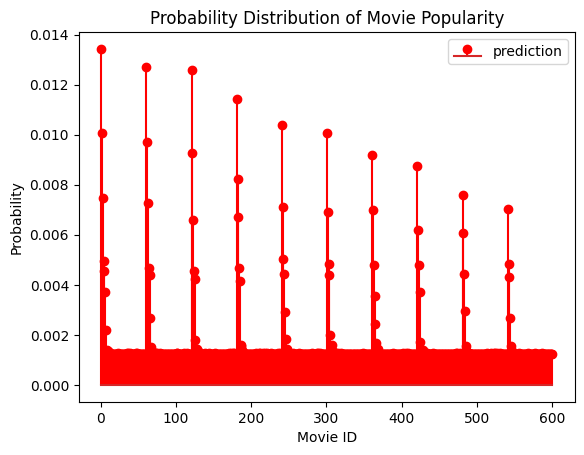

In [50]:
model1 = VAE().to("cuda:0")
model2 = VAE().to("cuda:0")

model1.load_state_dict(w1)
model2.load_state_dict(w2)

graph_m(model1)
graph_m(model2)